# How to Segment Buildings on Drone Imagery with Fast.ai & Cloud-Native GeoData Tools

## An Interactive Intro to Geospatial Deep Learning on Google Colab 




# Inference on new imagery

With our segmentation model trained and exported for inference use, we will now re-load it as an inference-only model to test on new unseen imagery. We'll test the generalizability of our trained segmentation model on tiles from drone imagery captured over another part of Zanzibar and in other parts of the world as well as at varying `zoom_levels` (locations and zoom levels indicated):

![](https://cdn-images-1.medium.com/max/1200/1*DaS2dVfeaxZCg6cqOcHDrg.jpeg)

We'll also compare our model inference time per tile on GPU versus CPU.

## Load exported model for inference

In [1]:
#!apt install python3-rtree libspatialindex-dev
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 18.0MB 242kB/s 
     |████████████████████████████████| 921kB 8.3MB/s 
     |████████████████████████████████| 11.8MB 30.3MB/s 
     |████████████████████████████████| 10.1MB 45.5MB/s 


In [2]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    590      0 --:--:-- --:--:-- --:--:--   590
Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python       : 3.6.9
fastai       : 1.0.60
fastprogress : 0.2.2
torch        : 1.3.1
torch cuda   : 10.1.243 / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro       : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env    : Unknown
python       : /usr/bin/python3
sys.path     : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utility to get the additional information


In [0]:
# Imports
import tqdm

In [0]:
# TODO: look into better way of loading export.pkl w/o needing to redefine these custom classes

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom
    
def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1) == target).float().mean()

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        ch_loss=0
        for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
            ch_loss+=loss_wt*loss_func(output[:,1,None], target[:,0,None])
        loss+=1*(ch_loss)
        return loss/sum(self.ch_wts)

# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels
def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,0,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,0,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)


In [7]:
# to mount and transfer to GDrive: uncomment and run this and the next cell, follow instructions to auhorize access to your GDrive
from google.colab import drive
drive.mount('/content/drive')
base_path="/content/drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
inference_learner = load_learner(path='/content/drive/My Drive/models/', file='rio0001trn-focaldice-unfrozen.pkl')

## Imports

In [0]:
import skimage 
import time
from skimage import io
from PIL import Image as PILImage


## Inference on new unseen tiles


In [0]:
original_size = (438, 406)
#path_istanbul = base_path + "istanbul-output-z17/all_tiles/"
path_istanbul = base_path + "istanbul-beyoglu-output-z18/all_tiles/"

def get_pred(learner, tile):
#     pdb.set_trace()
    t_img = Image(pil2tensor(PILImage.fromarray(test_tile[:,:,:3]).resize(original_size),np.float32).div_(255))
    outputs = learner.predict(t_img)
    im = image2np(outputs[2].sigmoid())[:, :, 1]
    im = (im*255).astype('uint8')
    return im, t_img

In [11]:
print(path_istanbul)

/content/drive/My Drive/istanbul-beyoglu-output-z18/all_tiles/


In [0]:
# try a different tile by changing or adding your own urls to list
import os

urls = []
count = 0
for subdir, dirs, files in os.walk(path_istanbul):
  for file in files:
    if file.endswith((".tif")):
      count = count + 1
      urls.append(path_istanbul + file)
      #if(count > 14):
      #  break

In [13]:
len(urls)

960

### On CPU

In [0]:
prediction_path = base_path + "predictions-beyoglu/"
shutil.rmtree(prediction_path)
os.makedirs(prediction_path)


In [16]:
#predictions = []
for url in tqdm.tqdm(urls):
  output_file = prediction_path + os.path.basename(url)
  #print(output_file)
  if os.path.isfile(output_file):
    print("omitted!")
  else:
    t1 = time.time()
    test_tile = skimage.io.imread(url)
    #print(url)
    result, resized = get_pred(inference_learner, test_tile)
    #predictions.append(result)
    PILImage.fromarray(result).resize(test_tile.shape[:2]).save(output_file)
    t2 = time.time()
  '''
  print(f'CPU inference took {t2-t1:.2f} secs')
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
  ax1.imshow(image2np(resized.px))
  ax2.imshow(test_tile)
  ax3.imshow(result)
  ax4.imshow((result > threshold).astype(float))
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  plt.show()
  '''

100%|██████████| 960/960 [58:19<00:00,  3.68s/it]


In [0]:
assert(len([name for name in os.listdir(prediction_path)]) == len(urls))

In [19]:
len([name for name in os.listdir(prediction_path)])

960

# Post-processing

## Predict on a tile, threshold and apply YUAN distance to obtain the final heatmap. Record coordinates to facilitate a further composition of images.

Once the model is trained, and we have Istanbul (or some districts) map divided into 406x438px tiles where each axis contains 200m, we perform 4 steps: ask for prediction to our fabulous model, threshold the output heatmap and applying signed distance transformation function.

Using solaris and geopandas, we'll convert our model's prediction as a 3-channel pixel raster output into a GeoJSON file by:

1. thresholding and combining the 3-channels of pixel values in our raw prediction output into a 1 channel binary pixel mask
2. Apply YUAN distance



In [0]:
import tqdm
from affine import Affine
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
import math
import geopandas as gpd
import skimage

In [0]:
from math import log, tan, radians, cos, pi, floor, degrees, atan, sinh
def sec(x):
    return(1/cos(x))


def latlon_to_xyz(lat, lon, z):
    tile_count = pow(2, z)
    x = (lon + 180) / 360
    y = (1 - log(tan(radians(lat)) + sec(radians(lat))) / pi) / 2
    return(tile_count*x, tile_count*y)


def bbox_to_xyz(lon_min, lon_max, lat_min, lat_max, z):
    x_min, y_max = latlon_to_xyz(lat_min, lon_min, z)
    x_max, y_min = latlon_to_xyz(lat_max, lon_max, z)
    return(floor(x_min), floor(x_max),
           floor(y_min), floor(y_max))


def mercatorToLat(mercatorY):
    return(degrees(atan(sinh(mercatorY))))


def y_to_lat_edges(y, z):
    tile_count = pow(2, z)
    unit = 1 / tile_count
    relative_y1 = y * unit
    relative_y2 = relative_y1 + unit
    lat1 = mercatorToLat(pi * (1 - 2 * relative_y1))
    lat2 = mercatorToLat(pi * (1 - 2 * relative_y2))
    return(lat1, lat2)


def x_to_lon_edges(x, z):
    tile_count = pow(2, z)
    unit = 360 / tile_count
    lon1 = -180 + x * unit
    lon2 = lon1 + unit
    return(lon1, lon2)


def tile_edges(x, y, z):
    lat1, lat2 = y_to_lat_edges(y, z)
    lon1, lon2 = x_to_lon_edges(x, z)
    return[lon1, lat1, lon2, lat2]

In [22]:
from shapely.geometry import Polygon, shape, Point
import gdal
import os
import numpy as np

def georeference_raster_tile(tile_filepath, output_path):
  filename, extension = os.path.splitext(os.path.basename(tile_filepath))
  x = int(filename.split("_")[0])
  y = int(filename.split("_")[1])
  z = int(filename.split("_")[2])
  bounds = tile_edges(x, y, z)
  gdal.Translate(output_path + filename + extension, tile_filepath,
                outputSRS='EPSG:4326',
                outputBounds=bounds)

import re
zoom_level = re.split('_', os.path.splitext(urls[0])[0])[-1]
dict_zoom_meterspixel = {'17': 1.193, '18': 0.596} # meters per each pixel
zoom_level

'18'

# Georeference prediction tiles before merging

In [0]:
geo_path = base_path + "geo-predictions-beyoglu/"
shutil.rmtree(geo_path)
os.makedirs(geo_path)

In [0]:
#raw_pred_big = skimage.io.imread('/content/drive/My Drive/predictions-beyoglu/152166_98243_18.tif')
#skimage.io.imshow(raw_pred_big)
#from PIL import Image
#im = Image.open('/content/drive/My Drive/merged_istanbul_fatih_raw.tif')
#im.show()

In [24]:
input_path = prediction_path
for subdir, dirs, files in os.walk(input_path):
  for file in tqdm.tqdm(files):
    if file.endswith((".tif")):
      output_file = input_path + file
      geo_output_file = geo_path + file
      if os.path.isfile(geo_output_file): # don't overwrite
        print("omitted!")
      else:
        print(geo_output_file)
        georeference_raster_tile(output_file, geo_path)

  0%|          | 4/960 [00:00<00:34, 27.92it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152166_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98249_18.tif


  1%|          | 11/960 [00:00<00:32, 29.38it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152166_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98256_18.tif


  2%|▏         | 19/960 [00:00<00:30, 30.61it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152166_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98263_18.tif


  2%|▏         | 23/960 [00:00<00:31, 29.29it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152167_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98237_18.tif


  3%|▎         | 31/960 [00:01<00:32, 28.85it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152167_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98243_18.tif


  4%|▎         | 35/960 [00:01<00:31, 29.64it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152167_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98250_18.tif


  4%|▍         | 43/960 [00:01<00:30, 29.74it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152167_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98256_18.tif


  5%|▌         | 50/960 [00:01<00:29, 30.81it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152167_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152167_98263_18.tif


  6%|▌         | 58/960 [00:01<00:30, 29.91it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152168_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98238_18.tif


  6%|▋         | 62/960 [00:02<00:33, 26.79it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152168_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98243_18.tif


  7%|▋         | 68/960 [00:02<00:32, 27.81it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152168_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98249_18.tif


  8%|▊         | 75/960 [00:02<00:30, 29.05it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152168_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98256_18.tif


  9%|▊         | 83/960 [00:02<00:28, 30.29it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152168_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152168_98263_18.tif


  9%|▉         | 87/960 [00:02<00:28, 30.93it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152169_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98237_18.tif


 10%|▉         | 94/960 [00:03<00:29, 28.97it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152169_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98244_18.tif


 11%|█         | 102/960 [00:03<00:28, 30.00it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152169_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98251_18.tif


 11%|█▏        | 110/960 [00:03<00:27, 30.82it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152169_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98258_18.tif


 12%|█▏        | 114/960 [00:03<00:29, 28.57it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152169_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152169_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98232_18.tif


 12%|█▎        | 120/960 [00:04<00:29, 28.40it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152170_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98238_18.tif


 13%|█▎        | 126/960 [00:04<00:30, 27.59it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152170_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98244_18.tif


 14%|█▍        | 132/960 [00:04<00:31, 26.59it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152170_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98250_18.tif


 15%|█▍        | 140/960 [00:04<00:27, 29.30it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152170_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98257_18.tif


 15%|█▌        | 147/960 [00:05<00:27, 29.22it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152170_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152170_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98232_18.tif


 16%|█▌        | 151/960 [00:05<00:26, 30.44it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152171_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98238_18.tif


 17%|█▋        | 159/960 [00:05<00:26, 30.53it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152171_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98245_18.tif


 17%|█▋        | 167/960 [00:05<00:26, 30.26it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152171_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98251_18.tif


 18%|█▊        | 171/960 [00:05<00:25, 30.48it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152171_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98257_18.tif


 19%|█▊        | 179/960 [00:06<00:26, 29.75it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152171_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152171_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98232_18.tif


 19%|█▉        | 187/960 [00:06<00:25, 30.60it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152172_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98239_18.tif


 20%|█▉        | 191/960 [00:06<00:28, 27.18it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152172_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98244_18.tif


 21%|██        | 197/960 [00:06<00:31, 24.13it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152172_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98249_18.tif


 21%|██        | 201/960 [00:06<00:29, 25.64it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152172_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98255_18.tif


 22%|██▏       | 207/960 [00:07<00:28, 26.69it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152172_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98261_18.tif


 22%|██▏       | 213/960 [00:07<00:26, 27.99it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152172_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152172_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98235_18.tif


 23%|██▎       | 220/960 [00:07<00:25, 28.73it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152173_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98242_18.tif


 24%|██▎       | 226/960 [00:07<00:26, 28.05it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152173_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98248_18.tif


 24%|██▍       | 233/960 [00:08<00:25, 28.57it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152173_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98254_18.tif


 25%|██▍       | 236/960 [00:08<00:25, 28.03it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152173_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98259_18.tif


 25%|██▌       | 243/960 [00:08<00:31, 22.90it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152173_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152173_98263_18.tif


 26%|██▌       | 246/960 [00:08<00:30, 23.17it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152174_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98237_18.tif


 26%|██▋       | 254/960 [00:08<00:26, 26.15it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152174_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98244_18.tif


 27%|██▋       | 261/960 [00:09<00:25, 27.31it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152174_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98250_18.tif


 28%|██▊       | 269/960 [00:09<00:23, 29.16it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152174_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98257_18.tif


 29%|██▊       | 275/960 [00:09<00:25, 27.12it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152174_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152174_98263_18.tif


 29%|██▉       | 281/960 [00:09<00:25, 26.70it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152175_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98237_18.tif


 30%|██▉       | 287/960 [00:10<00:25, 26.86it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152175_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98243_18.tif


 31%|███       | 294/960 [00:10<00:23, 28.55it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152175_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98250_18.tif


 31%|███▏      | 300/960 [00:10<00:23, 27.68it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152175_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98256_18.tif


 32%|███▏      | 306/960 [00:10<00:23, 27.90it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152175_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152175_98262_18.tif


 32%|███▏      | 309/960 [00:10<00:24, 26.20it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152175_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98236_18.tif


 33%|███▎      | 316/960 [00:11<00:23, 27.55it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152176_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98243_18.tif


 34%|███▍      | 324/960 [00:11<00:21, 30.28it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152176_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98250_18.tif


 35%|███▍      | 332/960 [00:11<00:22, 27.94it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152176_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98255_18.tif


 35%|███▍      | 335/960 [00:11<00:25, 24.77it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152176_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98260_18.tif


 36%|███▌      | 341/960 [00:12<00:24, 24.97it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152176_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152176_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98234_18.tif


 36%|███▌      | 347/960 [00:12<00:24, 25.31it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152177_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98240_18.tif


 37%|███▋      | 353/960 [00:12<00:23, 25.80it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152177_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98246_18.tif


 38%|███▊      | 360/960 [00:12<00:21, 27.95it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152177_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98252_18.tif


 38%|███▊      | 366/960 [00:13<00:21, 27.34it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152177_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98258_18.tif


 39%|███▉      | 372/960 [00:13<00:22, 26.60it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152177_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152177_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98232_18.tif


 39%|███▉      | 379/960 [00:13<00:20, 28.71it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152178_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98239_18.tif


 40%|████      | 386/960 [00:13<00:19, 28.79it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152178_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98246_18.tif


 41%|████      | 393/960 [00:13<00:19, 29.79it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152178_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98252_18.tif


 41%|████▏     | 397/960 [00:14<00:18, 30.57it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152178_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98258_18.tif


 42%|████▏     | 404/960 [00:14<00:19, 28.00it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152178_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152178_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98232_18.tif


 43%|████▎     | 410/960 [00:14<00:20, 26.86it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152179_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98237_18.tif


 43%|████▎     | 413/960 [00:14<00:19, 27.55it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152179_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98243_18.tif


 44%|████▍     | 420/960 [00:14<00:19, 27.90it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152179_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98250_18.tif


 44%|████▍     | 427/960 [00:15<00:19, 27.17it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152179_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98256_18.tif


 45%|████▌     | 433/960 [00:15<00:19, 26.52it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152179_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152179_98262_18.tif


 46%|████▌     | 439/960 [00:15<00:19, 27.36it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152179_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98236_18.tif


 46%|████▋     | 446/960 [00:15<00:17, 28.75it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152180_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98243_18.tif


 47%|████▋     | 453/960 [00:16<00:18, 27.29it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152180_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98249_18.tif


 48%|████▊     | 459/960 [00:16<00:18, 27.19it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152180_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98255_18.tif


 48%|████▊     | 465/960 [00:16<00:18, 26.37it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152180_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98260_18.tif


 49%|████▉     | 468/960 [00:16<00:18, 26.75it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152180_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152180_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98234_18.tif


 49%|████▉     | 475/960 [00:16<00:17, 27.38it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152181_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98241_18.tif


 50%|█████     | 483/960 [00:17<00:15, 30.48it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152181_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98248_18.tif


 51%|█████     | 487/960 [00:17<00:15, 30.60it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152181_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98253_18.tif


 51%|█████▏    | 494/960 [00:17<00:17, 26.87it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152181_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98259_18.tif


 52%|█████▏    | 500/960 [00:17<00:17, 25.70it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152181_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152181_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98232_18.tif


 52%|█████▏    | 503/960 [00:17<00:17, 26.61it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152152_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98237_18.tif


 53%|█████▎    | 509/960 [00:18<00:17, 25.22it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152152_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98243_18.tif


 54%|█████▎    | 515/960 [00:18<00:17, 24.88it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152152_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98248_18.tif


 54%|█████▍    | 521/960 [00:18<00:16, 26.17it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152152_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98254_18.tif


 55%|█████▌    | 528/960 [00:18<00:15, 27.69it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152152_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98261_18.tif


 56%|█████▌    | 535/960 [00:19<00:15, 27.56it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152152_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152152_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98235_18.tif


 56%|█████▌    | 538/960 [00:19<00:15, 26.83it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152153_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98240_18.tif


 57%|█████▋    | 545/960 [00:19<00:15, 27.15it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152153_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98247_18.tif


 57%|█████▊    | 552/960 [00:19<00:15, 26.16it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152153_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98252_18.tif


 58%|█████▊    | 555/960 [00:19<00:15, 26.10it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152153_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98257_18.tif


 58%|█████▊    | 561/960 [00:20<00:15, 25.76it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152153_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152153_98263_18.tif


 59%|█████▉    | 567/960 [00:20<00:15, 25.93it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152154_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98237_18.tif


 60%|█████▉    | 573/960 [00:20<00:14, 26.38it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152154_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98242_18.tif


 60%|██████    | 579/960 [00:20<00:14, 25.94it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152154_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98248_18.tif


 61%|██████    | 585/960 [00:21<00:14, 25.20it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152154_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98253_18.tif


 61%|██████▏   | 588/960 [00:21<00:14, 24.84it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152154_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98258_18.tif


 62%|██████▏   | 595/960 [00:21<00:13, 26.96it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152154_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152154_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98233_18.tif


 63%|██████▎   | 601/960 [00:21<00:14, 25.32it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152155_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98238_18.tif


 63%|██████▎   | 607/960 [00:21<00:13, 25.54it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152155_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98243_18.tif


 64%|██████▎   | 610/960 [00:22<00:14, 23.65it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152155_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98248_18.tif


 64%|██████▍   | 616/960 [00:22<00:14, 24.42it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152155_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98253_18.tif


 65%|██████▍   | 622/960 [00:22<00:13, 25.45it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152155_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98259_18.tif


 66%|██████▌   | 629/960 [00:22<00:12, 26.98it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152155_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152155_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98234_18.tif


 66%|██████▋   | 637/960 [00:23<00:10, 29.81it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152156_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98241_18.tif


 67%|██████▋   | 641/960 [00:23<00:10, 29.07it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152156_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98248_18.tif


 68%|██████▊   | 648/960 [00:23<00:11, 26.77it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152156_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98253_18.tif


 68%|██████▊   | 654/960 [00:23<00:12, 24.17it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152156_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98258_18.tif


 69%|██████▉   | 660/960 [00:23<00:11, 25.30it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152156_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152156_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98232_18.tif


 69%|██████▉   | 663/960 [00:24<00:13, 21.73it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152157_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98237_18.tif


 70%|██████▉   | 670/960 [00:24<00:11, 25.19it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152157_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98244_18.tif


 70%|███████   | 676/960 [00:24<00:11, 25.78it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152157_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98249_18.tif


 71%|███████   | 682/960 [00:24<00:10, 25.52it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152157_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98255_18.tif


 72%|███████▏  | 688/960 [00:25<00:10, 24.76it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152157_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98260_18.tif


 72%|███████▏  | 691/960 [00:25<00:11, 23.58it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152157_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152157_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98233_18.tif


 73%|███████▎  | 697/960 [00:25<00:11, 23.70it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152158_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98238_18.tif


 73%|███████▎  | 703/960 [00:25<00:10, 25.28it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152158_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98244_18.tif


 74%|███████▍  | 709/960 [00:25<00:09, 25.37it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152158_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98249_18.tif


 74%|███████▍  | 712/960 [00:26<00:09, 25.87it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152158_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98254_18.tif


 75%|███████▍  | 718/960 [00:26<00:10, 23.99it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152158_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98259_18.tif


 75%|███████▌  | 724/960 [00:26<00:10, 22.60it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152158_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152158_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98232_18.tif


 76%|███████▌  | 727/960 [00:26<00:10, 21.46it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152159_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98237_18.tif


 76%|███████▋  | 733/960 [00:26<00:09, 23.08it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152159_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98244_18.tif


 77%|███████▋  | 740/960 [00:27<00:08, 25.24it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152159_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98249_18.tif


 78%|███████▊  | 746/960 [00:27<00:08, 25.53it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152159_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98254_18.tif


 78%|███████▊  | 752/960 [00:27<00:08, 25.70it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152159_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98260_18.tif


 79%|███████▉  | 759/960 [00:27<00:07, 27.32it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152159_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152159_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98235_18.tif


 80%|███████▉  | 765/960 [00:28<00:07, 26.42it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152160_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98241_18.tif


 80%|████████  | 768/960 [00:28<00:07, 27.16it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152160_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98247_18.tif


 81%|████████  | 775/960 [00:28<00:06, 26.65it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152160_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98253_18.tif


 81%|████████▏ | 782/960 [00:28<00:06, 27.28it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152160_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98259_18.tif


 82%|████████▏ | 788/960 [00:28<00:06, 28.00it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152160_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152160_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98234_18.tif


 83%|████████▎ | 794/960 [00:29<00:06, 26.52it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152161_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98240_18.tif


 83%|████████▎ | 800/960 [00:29<00:05, 27.26it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152161_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98245_18.tif


 84%|████████▍ | 807/960 [00:29<00:05, 27.21it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152161_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98251_18.tif


 84%|████████▍ | 810/960 [00:29<00:05, 26.04it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152161_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98256_18.tif


 85%|████████▌ | 816/960 [00:30<00:05, 25.86it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152161_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98261_18.tif


 86%|████████▌ | 822/960 [00:30<00:05, 25.79it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152161_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152161_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98235_18.tif


 86%|████████▋ | 828/960 [00:30<00:05, 24.33it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152162_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98240_18.tif


 87%|████████▋ | 831/960 [00:30<00:05, 25.70it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152162_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98245_18.tif


 87%|████████▋ | 837/960 [00:30<00:05, 22.52it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152162_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98250_18.tif


 88%|████████▊ | 843/960 [00:31<00:04, 24.24it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152162_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98255_18.tif


 88%|████████▊ | 849/960 [00:31<00:04, 24.68it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152162_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98261_18.tif


 89%|████████▉ | 852/960 [00:31<00:04, 22.63it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152162_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152162_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98234_18.tif


 89%|████████▉ | 858/960 [00:31<00:04, 22.90it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152163_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98239_18.tif


 90%|█████████ | 865/960 [00:32<00:03, 25.35it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152163_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98246_18.tif


 91%|█████████ | 871/960 [00:32<00:03, 25.46it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152163_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98251_18.tif


 91%|█████████ | 874/960 [00:32<00:03, 24.66it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152163_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98256_18.tif


 92%|█████████▏| 880/960 [00:32<00:03, 23.38it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152163_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98261_18.tif


 92%|█████████▏| 883/960 [00:32<00:03, 24.13it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152163_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152163_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98233_18.tif


 93%|█████████▎| 889/960 [00:33<00:03, 22.95it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152164_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98239_18.tif


 93%|█████████▎| 895/960 [00:33<00:02, 23.91it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152164_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98243_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98245_18.tif


 94%|█████████▍| 901/960 [00:33<00:02, 25.55it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152164_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98248_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98251_18.tif


 94%|█████████▍| 907/960 [00:33<00:02, 25.15it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152164_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98254_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98257_18.tif


 95%|█████████▌| 913/960 [00:34<00:01, 24.21it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152164_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98260_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152164_98262_18.tif


 96%|█████████▌| 920/960 [00:34<00:01, 26.98it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152164_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98233_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98237_18.tif


 96%|█████████▋| 926/960 [00:34<00:01, 23.57it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152165_98238_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98243_18.tif


 97%|█████████▋| 933/960 [00:34<00:01, 25.00it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152165_98244_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98245_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98246_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98247_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98248_18.tif


 98%|█████████▊| 936/960 [00:34<00:00, 24.61it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152165_98249_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98250_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98251_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98252_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98253_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98254_18.tif


 98%|█████████▊| 942/960 [00:35<00:00, 24.65it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152165_98255_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98256_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98257_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98258_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98259_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98260_18.tif


 99%|█████████▉| 948/960 [00:35<00:00, 24.46it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152165_98261_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98262_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152165_98263_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98232_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98233_18.tif


 99%|█████████▉| 954/960 [00:35<00:00, 24.05it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152166_98234_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98235_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98236_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98237_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98238_18.tif


100%|██████████| 960/960 [00:35<00:00, 25.07it/s]

/content/drive/My Drive/geo-predictions-beyoglu/152166_98239_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98240_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98241_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98242_18.tif
/content/drive/My Drive/geo-predictions-beyoglu/152166_98243_18.tif


In [0]:
assert(len([name for name in os.listdir(geo_path)]) == len(urls))

In [26]:
len([name for name in os.listdir(path_istanbul) if name.endswith((".tif"))])

960

# Merge all files into a single tile

In [28]:
base_path

'/content/drive/My Drive/'

In [0]:
import glob
def merge_tiles(input_pattern, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path]

    for name in glob.glob(input_pattern):
        merge_command.append(name)

    print("Number tiles to merge: " + str(len(merge_command) - 2))
    subprocess.call(merge_command)


# Merge raw predictions

In [29]:
geo_predictions_path = base_path + "geo-predictions-beyoglu/"
print("Merging tiles")
merge_tiles(geo_predictions_path + "*.tif", base_path + 'merged_beyoglu_raw-geo-predictions_v5.tif')
print("Merge complete")


Merging tiles
Number tiles to merge: 961
Merge complete


(8192, 7680)


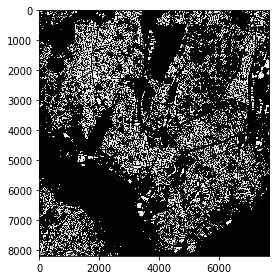

In [31]:
raw_pred_big = skimage.io.imread(base_path + 'merged_beyoglu_raw-geo-predictions_v5.tif', as_gray=True)
print(raw_pred_big.shape)
skimage.io.imshow(raw_pred_big)

In [0]:
satellital_big = skimage.io.imread(base_path + 'istanbul-beyoglu-output-z18/merge/merged.tif')

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30, 15))
ax1.set_title('Raw image')
ax1.imshow(satellital_big)
ax2.set_title('Final heatmap')
ax2.imshow(raw_pred_big)
ax3.set_title('Both overlapping')
ax3.imshow(satellital_big)
ax3.imshow(raw_pred_big, alpha=0.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [35]:
fig, (ax1) = plt.subplots(1,1,figsize=(20, 20))
ax1.set_title('Both overlapping')
ax1.imshow(raw_pred_big)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [36]:
fig, (ax1) = plt.subplots(1,1,figsize=(40, 20))
ax1.set_title('Both overlapping')
ax1.imshow(satellital_big)
ax1.imshow(raw_pred_big, alpha=0.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Compute distance transformation (Yuan et al.) for the mosaic


In [0]:
from PIL import Image as PILImage
from skimage import io
import skimage
import subprocess

threshold = 125
big_url_solution = base_path + 'merged_beyoglu_raw-geo-predictions_v5.tif'
tile = skimage.io.imread(big_url_solution)
#PILImage.fromarray((tile > threshold)).save(base_path + 'merged_istanbul_fatih_raw-geo-predictions_v2_binary.tif')

In [40]:
import cv2
import numpy as np

# Create a test image
bw_tile = (tile > threshold).astype(int)
t = (250, 1200)
pixel_pad = 25

def find_nearest_black(img, target, pixel_pad = 100):
    nearest_distance = 0
    if(img[target] == 0):
      xmin = max(target[0] - pixel_pad, 0)
      xmax = target[0] + pixel_pad
      ymin = max(target[1] - pixel_pad, 0)
      ymax = target[1] + pixel_pad
      local_target = (target[0] - xmin, target[1] - ymin)
      nonzero = cv2.findNonZero(img[xmin:xmax, ymin:ymax])
      if nonzero is not None:
        distances = np.sqrt((nonzero[:,:,0] - local_target[0]) ** 2 + (nonzero[:,:,1] - local_target[1]) ** 2)
        nearest_distance = np.min(distances)
        #positions = nonzero[np.argmin(distances)][0]
        #print(positions)
      else:
        nearest_distance = np.sqrt((pixel_pad * 2) ** 2 + (pixel_pad * 2) ** 2)
    return nearest_distance

import time
start = time.time()
print(find_nearest_black(bw_tile, t, pixel_pad))
end = time.time()
print(end - start)

70.71067811865476
0.013037681579589844


(225, 275, 1175, 1225)


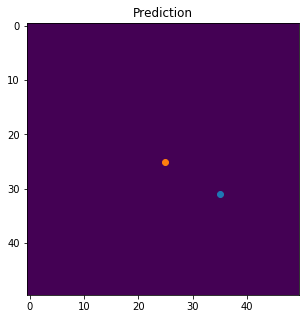

In [41]:
from matplotlib import pyplot as plt
fig, (ax1) = plt.subplots(1,1, figsize=(10,5))
xmin = max(t[0] - pixel_pad, 0)
xmax = t[0] + pixel_pad
ymin = max(t[1] - pixel_pad, 0)
ymax = t[1] + pixel_pad
local_target = (t[0] - xmin, t[1] - ymin)
print((xmin, xmax, ymin, ymax))
ax1.set_title('Prediction')
ax1.imshow(bw_tile[xmin:xmax, ymin:ymax])
ax1.scatter(35, 31)
ax1.scatter(local_target[0], local_target[1])
plt.show()

In [42]:
# Final execution
threshold = 125.0
bw_tile_array = (tile > threshold).astype(int)
n_pixel_pad = 100 # square tiles for computing distances will be of size (pixel_pad *2, pixel_pad * 2)
dist_matrix = np.zeros(bw_tile_array.shape)
for i in tqdm.tqdm(range(bw_tile_array.shape[0])):
    for j in range(bw_tile_array.shape[1]):
      dist_matrix[i,j] = find_nearest_black(bw_tile_array, (i,j), n_pixel_pad)


100%|██████████| 8192/8192 [2:24:45<00:00,  2.31it/s]


In [0]:
PILImage.fromarray(dist_matrix).convert('RGB').save(base_path + 'distance_beyoglu_big_raw_100.tif')
dist_matrix_metres = np.round(dist_matrix * float(dict_zoom_meterspixel[zoom_level]))
PILImage.fromarray(dist_matrix_metres).convert('RGB').save(base_path + 'distance_beyoglu_big_meters_100.tif')

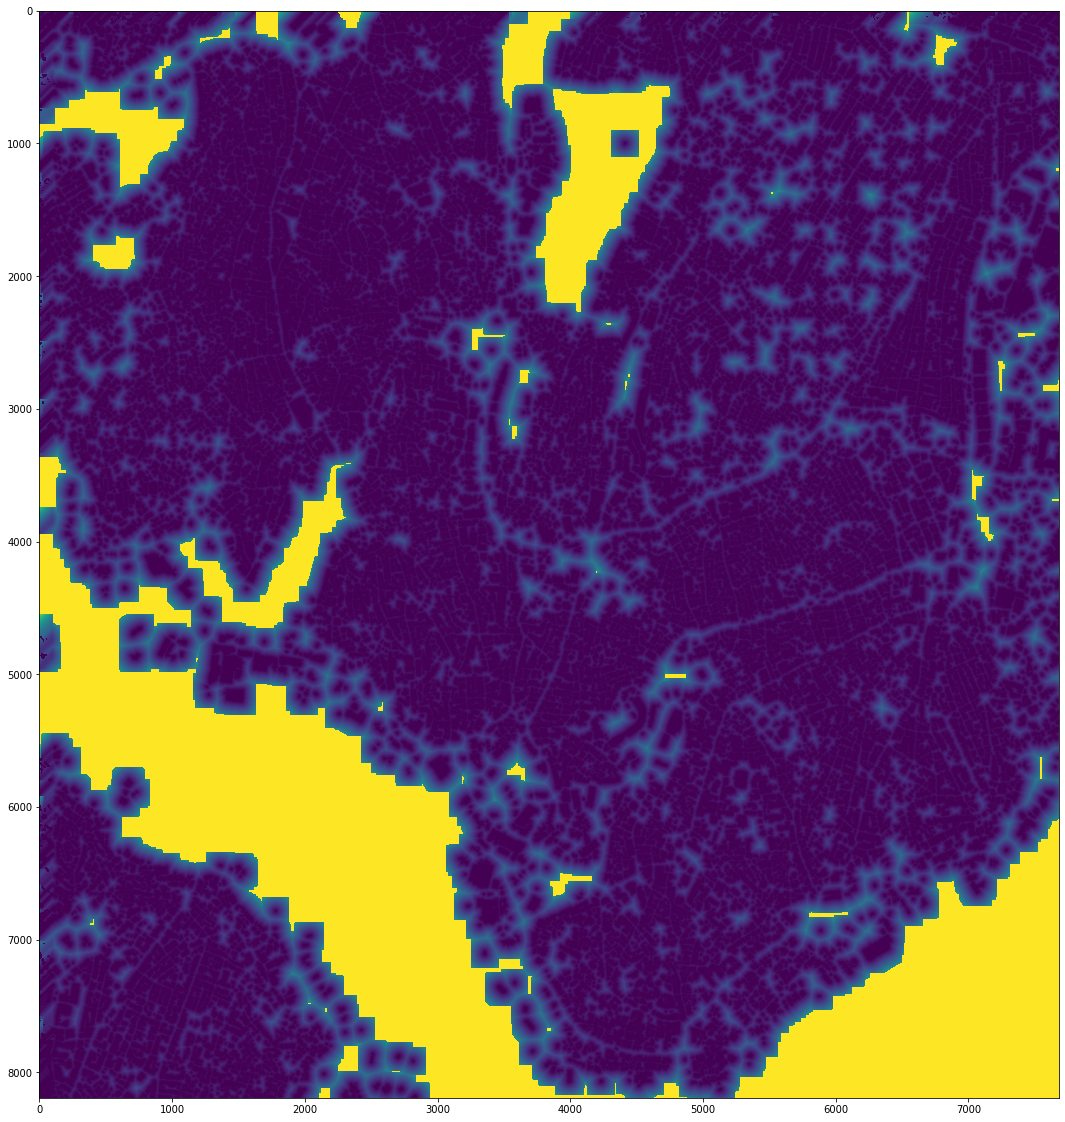

In [45]:
dist_matrix_picture = skimage.io.imread(base_path + 'distance_beyoglu_big_meters_100.tif', as_gray=True)
fig, (ax1) = plt.subplots(1,1,figsize=(20, 20))
ax1.imshow(dist_matrix_picture)
plt.show()

In [46]:
fig, (ax1) = plt.subplots(1,1,figsize=(15, 15))
ax1.set_title('Both overlapping')
ax1.imshow(satellital_big)
ax1.imshow(dist_matrix_picture, alpha=0.75)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Adjust matrix limits

In [58]:
dist_matrix_picture_raw = skimage.io.imread(base_path + 'distance_beyoglu_big_meters_100.tif')
import collections
unique, counts = np.unique(dist_matrix_picture_raw, return_counts=True)
counter = dict(zip(unique, counts))
counter

{0: 38920836,
 1: 11418849,
 2: 9291336,
 3: 7731393,
 4: 7325847,
 5: 7629279,
 6: 5052303,
 7: 5174070,
 8: 4592397,
 9: 3646980,
 10: 3644778,
 11: 3386631,
 12: 2540994,
 13: 2804259,
 14: 2482005,
 15: 2240406,
 16: 2060721,
 17: 1961601,
 18: 1807599,
 19: 1728189,
 20: 1593456,
 21: 1589409,
 22: 1403340,
 23: 1374792,
 24: 1281120,
 25: 1246281,
 26: 1206525,
 27: 1136214,
 28: 1012698,
 29: 1044156,
 30: 1016052,
 31: 907224,
 32: 911520,
 33: 875757,
 34: 804306,
 35: 839022,
 36: 745023,
 37: 681810,
 38: 751731,
 39: 682392,
 40: 608310,
 41: 647670,
 42: 617964,
 43: 557367,
 44: 571314,
 45: 545874,
 46: 513486,
 47: 488388,
 48: 484392,
 49: 473301,
 50: 438615,
 51: 449679,
 52: 397911,
 53: 393576,
 54: 415035,
 55: 376368,
 56: 353766,
 57: 373353,
 58: 357411,
 59: 343317,
 60: 283344,
 61: 250236,
 62: 225159,
 63: 195210,
 64: 170910,
 65: 175080,
 66: 153699,
 67: 151812,
 68: 130815,
 69: 119649,
 70: 123258,
 71: 103608,
 72: 103551,
 73: 98040,
 74: 89835,
 75:

In [0]:
new_max = sorted(counter.keys())[-2]
dist_matrix_picture_raw[dist_matrix_picture_raw > new_max] = new_max
PILImage.fromarray(dist_matrix_picture_raw).convert('RGB').save(base_path + 'distance_beyoglu_big_meters_100.tif')

In [59]:
dist_matrix_picture_raw.max()

131

In [53]:
dist_matrix_picture_raw = skimage.io.imread(base_path + 'distance_beyoglu_big_meters_100.tif', as_gray=True)
fig, (ax1) = plt.subplots(1,1,figsize=(15, 15))
ax1.set_title('Both overlapping')
ax1.imshow(satellital_big)
ax1.imshow(dist_matrix_picture_raw, alpha=0.75)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Pickle distance matrix

In [0]:
with open(base_path + 'distance_beyoglu_big_meters_100.pickle','wb') as f:
     pickle.dump(dist_matrix_picture_raw, f)

In [0]:
with open(base_path + 'distance_beyoglu_big_meters_100.pickle','rb') as f:
     tmp = pickle.load(f)

# Notebook Changelog

## v1 (2019-07-25):
-------
New: 1st public release

Changed: n/a

Fixed: n/a